# Trying first zero dce llie paper oss functions for our purpose

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision.models.vgg import vgg16
import numpy as np


class L_color(nn.Module):

    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)


        return k


class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        # print(1)kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).to(device).unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).to(device).unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)
    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        weight_diff =torch.max(torch.FloatTensor([1]).to(device) + 10000*torch.min(org_pool - torch.FloatTensor([0.3]).to(device),torch.FloatTensor([0]).to(device)),torch.FloatTensor([0.5]).to(device))
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).to(device)) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)
        # E = 25*(D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size,mean_val):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).to(device),2))
        return d

class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size
class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
        # print(1)
    def forward(self, x ):
        # self.grad = np.ones(x.shape,dtype=np.float32)
        b,c,h,w = x.shape
        # x_de = x.cpu().detach().numpy()
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)
        # print(k)


        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        # out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return h_relu_4_3

In [7]:
# skipped l_Exp as it require some params
device = "cuda" if torch.cuda.is_available() else "cpu"

perception_loss, Sa_Loss, L_TV, L_color, L_spa =  perception_loss(), Sa_Loss(), L_TV(), L_color(), L_spa()

In [15]:
z = perception_loss(original_img.float().permute(2,0,1))
k = perception_loss(modified_img.float().permute(2,0,1))
z.shape, k.shape

(torch.Size([512, 60, 78]), torch.Size([512, 60, 78]))

In [21]:
original_img.shape

torch.Size([480, 628, 3])

In [26]:
#saloss can be used
z1 = Sa_Loss(original_img.float().unsqueeze(0).permute(0,3,1,2))
k1 = Sa_Loss(modified_img.float().unsqueeze(0).permute(0,3,1,2))
z1, k1

(tensor(70.5933), tensor(96.4215))

In [12]:
original_img.shape

torch.Size([480, 628, 3])

In [27]:
#L_TV can be used
z1 = L_TV(original_img.float().unsqueeze(0).permute(0,3,1,2))
k1 = L_TV(modified_img.float().unsqueeze(0).permute(0,3,1,2))
z1, k1

(tensor(2042.2930), tensor(1946.8945))

In [28]:
# L_color, L_spa
z1 = L_color(original_img.float().unsqueeze(0).permute(0,3,1,2))
k1 = L_color(modified_img.float().unsqueeze(0).permute(0,3,1,2))
z1, k1

(tensor([[[[37.6172]]]]), tensor([[[[54.9808]]]]))

In [31]:
k1 = L_spa(modified_img.float().unsqueeze(0).permute(0,3,1,2), original_img.float().unsqueeze(0).permute(0,3,1,2))
k1.shape

torch.Size([1, 1, 120, 157])

In [32]:
k1.unique()

tensor([0.0000e+00, 6.8138e+00, 7.3051e+00,  ..., 3.8263e+04, 4.0051e+04,
        5.4238e+04])

#OTHERS

torch.Size([480, 628, 3])
torch.Size([480, 628])


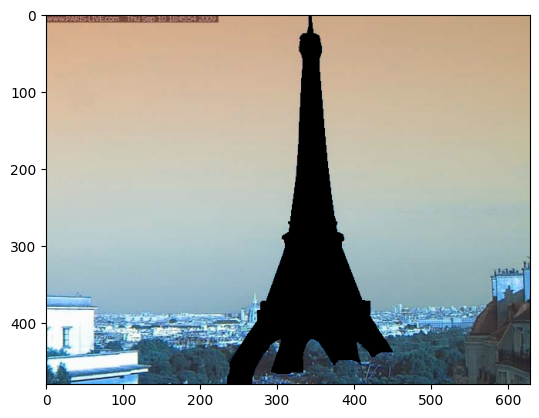

In [1]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import torch
import matplotlib.pyplot as plt

# imread -> np array || Image.open => pillow image

original_img = torch.tensor(cv2.imread("d90000003-9.jpg"))  #<path to img>
modified_img = original_img.clone()
mask = torch.tensor(cv2.imread("d90000003-9_1.png",cv2.IMREAD_GRAYSCALE)) #[:,:,0]   #<path to mask>
print(original_img.shape)
print(mask.shape)   # why the mask is a 3d img?

modified_img[:,:,0][mask == 255] = 0
modified_img[:,:,1][mask == 255] = 0
modified_img[:,:,2][mask == 255] = 0

plt.imsave(fname='modified_img.jpg', arr=modified_img.numpy())
plt.imshow(modified_img)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
mask.unique()

tensor([  0, 255], dtype=torch.uint8)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load a pre-trained model
model = models.segmentation.fcn_resnet50(pretrained=True)
model.eval()

# Load and preprocess the image
# image = Image.open('modified_img.jpg') #NEW
image = Image.open('d90000003-9.jpg')
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0) # Create a mini-batch

# Perform inference
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# Get confidence scores
softmax = torch.nn.functional.softmax(output, dim=0)
confidence_scores = softmax.max(0)[0]  # Maximum confidence score for each pixel
average_confidence = confidence_scores.mean().item()
print('Average confidence score:', average_confidence)

# of masked img ==> Average confidence score: 0.9976255297660828
# of original img ==> Average confidence score: 0.9980064630508423

#another modified img => Average confidence score: 0.9459970593452454
# of orignal image other => Average confidence score: 0.9901702404022217


Average confidence score: 0.9901702404022217


In [ ]:
#consistency check
from PIL import Image
from torchvision import transforms

# image = Image.open('d90000003-9.jpg')
image = Image.open('modified_img.jpg')

# Define different augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
])

# Apply augmentations and get predictions
num_augmentations = 5
predictions = []
for _ in range(num_augmentations):
    augmented_image = augmentations(image)
    input_batch = augmented_image.unsqueeze(0)
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    predictions.append(output.argmax(0))

# Check consistency
consistency_score = torch.stack(predictions).float().std(0).mean().item()
print('Consistency score:', consistency_score)
# of masked img ==> Consistency score: 0.024443356320261955
#of origi

#of  another masked image => Consistency score: 0.7978749871253967, Consistency score: 0.2549079656600952
#of original image => Consistency score: 0.026560723781585693


IndexError: too many indices for tensor of dimension 2

In [ ]:
# Anomaly detection (using a pre-trained autoencoder, for example)
# Assuming `autoencoder` is a pre-trained autoencoder model
reconstructed = autoencoder(input_batch)
reconstruction_error = ((input_batch - reconstructed) ** 2).mean()
print('Reconstruction error:', reconstruction_error.item())


In [ ]:
#class activation map
import torchvision.models as models
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

model = models.resnet50(pretrained=True)
# model.eval()
model.train()


preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Hook to get the gradients of the target layer
def hook_fn(module, input, output):
    global features_gradients
    features_gradients = input[0].clone()

# Register hook to the final layer
target_layer = model.layer4[-1].conv2
target_layer.register_backward_hook(hook_fn)

# Get model predictions and gradients
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0).requires_grad_(True)

output = model(input_batch)

print(output.argmax())
output.argmax().backward()

# Get the gradients and the activations
gradients = features_gradients.detach().cpu().numpy()
activations = target_layer(output).detach().cpu().numpy()

# Calculate CAM
weights = np.mean(gradients, axis=(2, 3))
cam = np.zeros(activations.shape[2:], dtype=np.float32)

for i, w in enumerate(weights[0]):
    cam += w * activations[0, i, :, :]

# Apply ReLU and normalize
cam = np.maximum(cam, 0)
cam = cam / np.max(cam)

# Resize CAM to match input image size
cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[1]))

# Visualize CAM
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()


tensor(600)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# check blur img with laplacian filter
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'd90000003-9.jpg'
image_path = 'modified_img.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Compute the Laplacian of the image and then the variance
laplacian = cv2.Laplacian(image, cv2.CV_64F)
variance_of_laplacian = laplacian.var()

print(f'Variance of Laplacian: {variance_of_laplacian}')

# Threshold for detecting blur (can be adjusted)
blur_threshold = 100.0
if variance_of_laplacian < blur_threshold:
    print("The image is blurry.")
else:
    print("The image is not blurry.")

# originalimage=============>> Variance of Laplacian: 836.6034531726372 The image is not blurry.
# modified_img=============>>Variance of Laplacian: 791.0655749018191  The image is not blurry.


Variance of Laplacian: 791.0655749018191
The image is not blurry.


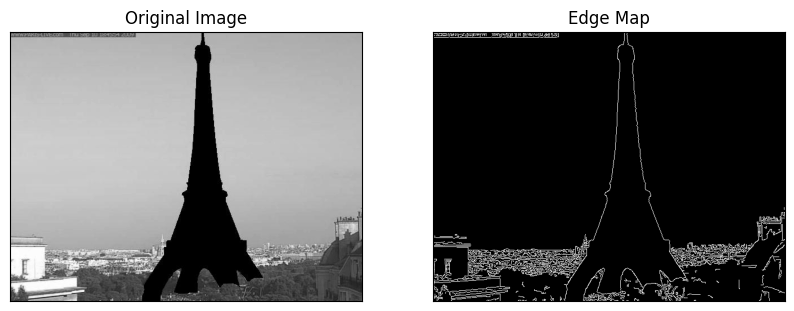

In [ ]:
#canny edge detection
edges = cv2.Canny(image, 100, 200)

# Display the edges
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Map'), plt.xticks([]), plt.yticks([])
plt.show()


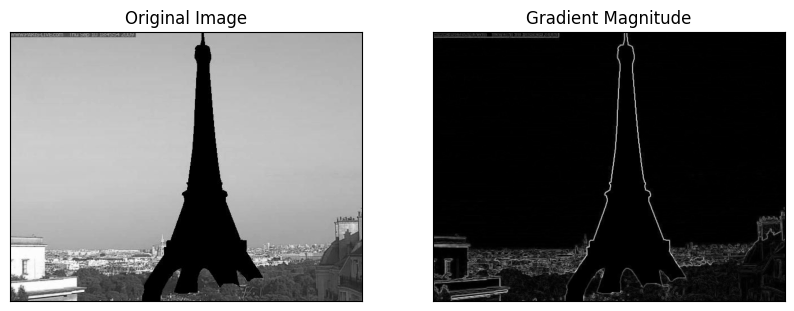

In [ ]:
# check local contrast
# Calculate the gradient magnitude using Sobel filters
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# Normalize the gradient magnitude to the range [0, 255]
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
gradient_magnitude = gradient_magnitude.astype(np.uint8)

# Display the gradient magnitude
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude'), plt.xticks([]), plt.yticks([])
plt.show()
